# Tutorial 9: GAN

## Imports

In [ ]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
import torchvision.datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils
from tqdm.auto import tqdm, trange

## GAN

This part is modified from [here](https://github.com/tomsercu/gan-tutorial-pytorch/blob/master/2019-04-23%20GAN%20Tutorial%20with%20outputs.ipynb)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def show_imgs(x, new_fig=True):
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure(figsize=(10, 10))
    plt.imshow(grid.numpy())

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, inp_dim=784):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(inp_dim, 128)
        self.nonlin1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(128, 1)
    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten (bs x 1 x 28 x 28) -> (bs x 784)
        h = self.nonlin1(self.fc1(x))
        out = self.fc2(h)
        out = torch.sigmoid(out)
        return out

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 128)
        self.nonlin1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(128, 784)
    def forward(self, x):
        h = self.nonlin1(self.fc1(x))
        out = self.fc2(h)
        out = torch.tanh(out) # range [-1, 1]
        # convert to image 
        out = out.view(out.size(0), 1, 28, 28)
        return out

In [9]:
dataset = torchvision.datasets.FashionMNIST(root='.',
                       transform=transforms.Compose([transforms.ToTensor(),
                                                     transforms.Normalize((0.5,), (0.5,))]),
                       download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

Using downloaded and verified file: ./FashionMNIST/raw/train-images-idx3-ubyte.gz
Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw
Using downloaded and verified file: ./FashionMNIST/raw/train-labels-idx1-ubyte.gz
Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw
Using downloaded and verified file: ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw
Using downloaded and verified file: ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw
Processing...


/opt/anaconda3/envs/python3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1595629449223/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [12]:
device='cpu'
D = Discriminator().to(device)
G = Generator().to(device)
# Now let's set up the optimizers (Adam, better than SGD for this)
optimizerD = torch.optim.SGD(D.parameters(), lr=0.03)
optimizerG = torch.optim.SGD(G.parameters(), lr=0.03)
# optimizerD = torch.optim.Adam(D.parameters(), lr=0.0002)
# optimizerG = torch.optim.Adam(G.parameters(), lr=0.0002)
lab_real = torch.ones(64, 1, device=device)
lab_fake = torch.zeros(64, 1, device=device)

criterion = nn.BCELoss()

# for logging:
collect_x_gen = []
fixed_noise = torch.randn(64, 100, device=device)
x_gen = G(fixed_noise)
collect_x_gen.append(x_gen.detach().clone())
fig = plt.figure() # keep updating this one
plt.ion()

for epoch in trange(5):
    for data in tqdm(dataloader, leave=False):
        # STEP 1: Discriminator optimization step
        x_real, _ = iter(dataloader).next()
        x_real = x_real.to(device)
        # reset accumulated gradients from previous iteration
        optimizerD.zero_grad()

        D_x = D(x_real)
        lossD_real = criterion(D_x, lab_real)

        z = torch.randn(64, 100, device=device) # random noise, 64 samples, z_dim=100
        x_gen = G(z).detach()
        D_G_z = D(x_gen)
        lossD_fake = criterion(D_G_z, lab_fake)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()
        
        # STEP 2: Generator optimization step
        # reset accumulated gradients from previous iteration
        optimizerG.zero_grad()

        z = torch.randn(64, 100, device=device) # random noise, 64 samples, z_dim=100
        x_gen = G(z)
        D_G_z = D(x_gen)
        lossG = criterion(D_G_z, lab_real) # -log D(G(z))

        lossG.backward()
        optimizerG.step()
    # End of epoch
    x_gen = G(fixed_noise)
    collect_x_gen.append(x_gen.detach().clone())

<Figure size 432x288 with 0 Axes>

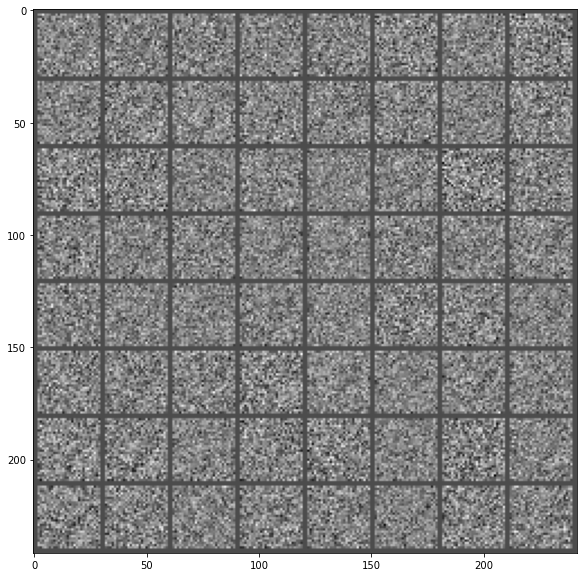

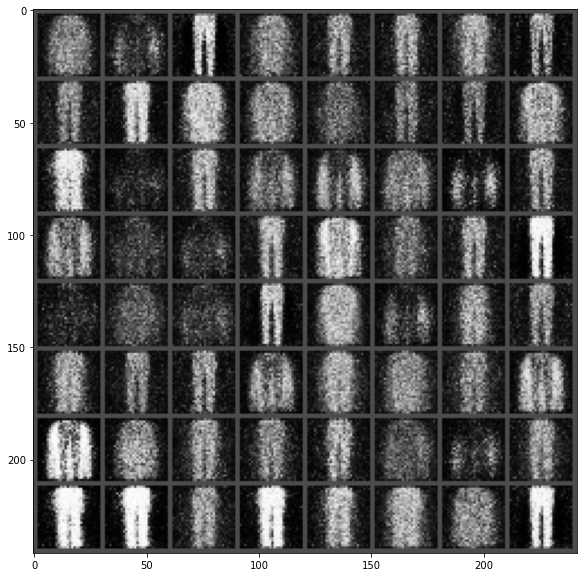

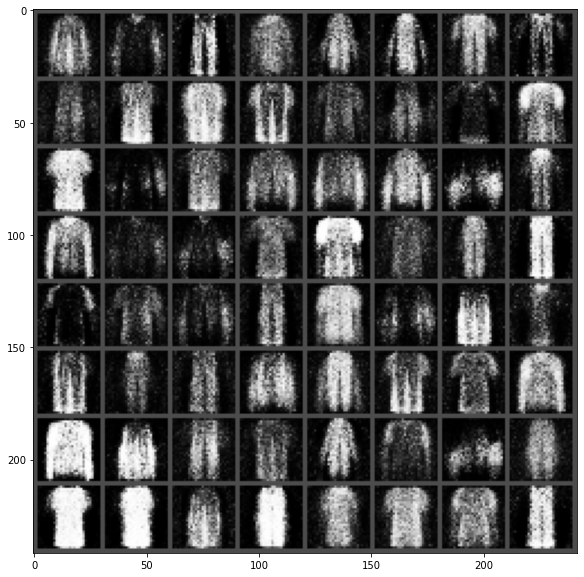

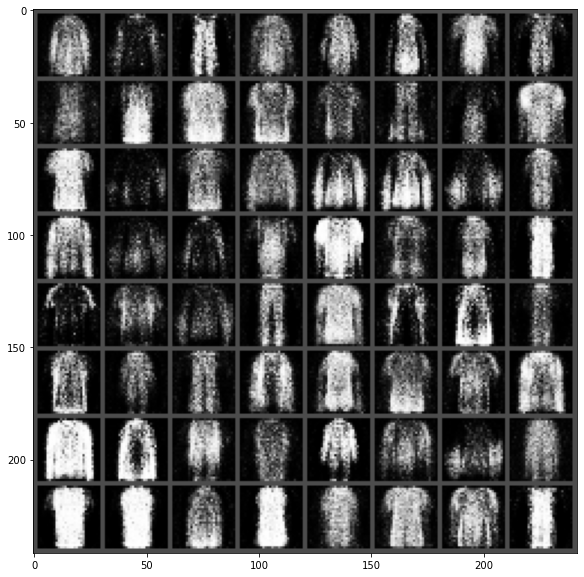

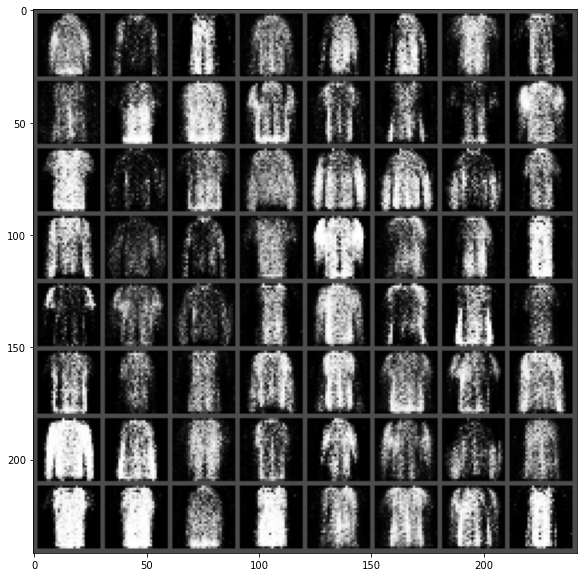

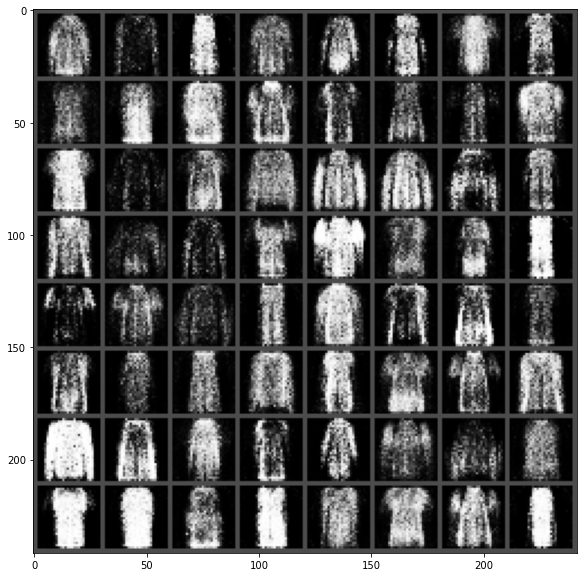

In [13]:
for x_gen in collect_x_gen:
    show_imgs(x_gen)